# 机器学习报告四:朴素贝叶斯分类器
- 姓名：李欣
- 学号：2011165
- 专业：计算机科学与技术

### 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。 
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

### 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

## 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。 
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

### 划分训练集和数据集

#### 需要的包

In [1]:
    # 需要的包
    # -*- coding: UTF-8 -*-
    import math
    import numpy as np  
    import pandas as pd
    import random
    import matplotlib.pyplot as plt

#### 导入数据集

In [2]:
    f = open('wine.data','r')
    types = [[],[],[]]                      #按类分的所有数据
    test_data = [[],[],[]]                  #测试数据
    train_data = [[],[],[]]                 #训练数据
    data_num = 0                            #数据总数
    test_len = []                           #测试集里每一类的个数
    means = [[],[],[]]                      #每一类的均值
    std = [[],[],[]]                        #每一类的标准差
    myline = '1'
    #切分数据
    while myline:
        # 以分号为分隔
        myline = f.readline().split(',')
        if len(myline) != 14:
            break
        for t in range(len(myline)):
            if t == 0:
                # 第一个是分类
                myline[t] = int(myline[t])
            else:
                # 后面的是特征值，为float
                myline[t] = float(myline[t])
        # 弹出该行第1个元素，myline删除了第0个元素:分类
        temp = myline.pop(0)
        # 相应类型加入该行(去掉‘,’和第0个元素:分类)
        types[temp - 1].append(myline)

    # 按照7：3划分训练集和测试集，采用分层随机采样
    test_len = [round(len(types[i])*0.3) for i in range(3)] 
    # 数据总数
    data_num = len(types[0])+len(types[1])+len(types[2])
    types_len = [round(len(types[i])) for i in range(3)] 

In [3]:
    # 打印
    types_len = [round(len(types[i])) for i in range(3)] 
    print("测试集大小：",test_len)
    train_len = [round(types_len[i]-test_len[i]) for i in range(3)]
    print("训练集大小：", train_len)
    print("数据集总和：",data_num)

测试集大小： [18, 21, 14]
训练集大小： [41, 50, 34]
数据集总和： 178


#### 分层随机采样

In [4]:
    # 划分训练集和测试集
    # DataCount三类样本的索引
    DataCount=[list(range(np.array(types[i]). shape[0])) for i in range(3)]
    # DataCount
    total_num=[len(DataCount[i]) for i in range(3)]
    #对于第i类
    for i in range(len(DataCount)):
        #随机抽取了个样本
        for j in range(test_len[i]):
            randIndex = int(random.uniform(0, len(DataCount[i])))
            # 向test_data的第i类的list中加入这一数据
            test_data[i].append(np.array(types[i])[randIndex,:])
            # 删除这个索引，便于下一次随机抽取
            del(DataCount[i][randIndex])
        # 剩余的索引对应的行加入训练集
        for j in range (len(DataCount[i])):
            train_data[i].append(np.array(types[i])[j,:])

    for i in range (3):
        print("{}类训练样本个数：{}".format(i+1,len(DataCount[i])))
        print("{}类测试样本个数：{}".format(i+1,total_num[i]-len(DataCount[i])))    

1类训练样本个数：41
1类测试样本个数：18
2类训练样本个数：50
2类测试样本个数：21
3类训练样本个数：34
3类测试样本个数：14


In [5]:
data_num
types_len = [round(len(types[i])) for i in range(3)]
types_len

178

[59, 71, 48]

[![MommyTalk1668481984954.jpg](https://img1.imgtp.com/2022/11/15/SU2tAHua.jpg)](https://img1.imgtp.com/2022/11/15/SU2tAHua.jpg)

In [6]:
# 测试数据在某一类别条件下为该类的概率
def Bayes_Probability(std, test_data, mean,this_class):
    p=np.log(math.sqrt(2 * math.pi) * std)+np.power(test_data - mean, 2) / (2 * np.power(std, 2))
    p=np.sum(p)
    p = -1*p+math.log(types_len[this_class]/data_num)
    return p

In [7]:
def bayes_classificate(train_data,test_data):
    '''
        pre_y:预测标签
        test_y:真实标签
    '''
    pre_y=[]   # 预测值
    test_y=[]  # 真实值
    probablity_3class=[] # 某条数据为某类的可能性[prob_1,prob_2,prob_3]
    #每个类 每一列(即每个属性的均值)
    means=[np.mean(train_data[i],axis=0) for i in range(3)] #均值向量
    
    #每个类 每一列(即每个属性的标准差) 
    std=[np.std(train_data[i],axis=0)for i in range(3)]     #标准差
    
    wrong_num = 0 # 预测错误的个数
    for i in range(3):
        for t in test_data[i]:                  #两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                #由于数据集中所有的属性都是连续值，
                #连续值的似然估计可以按照高斯分布来计算：
                temp = Bayes_Probability(std[j],t,means[j],j)
                my_type.append(temp)        #这里将所有score保存
            pre_type = my_type.index(max(my_type))
            probablity_3class.append(my_type)
            pre_y.append(pre_type)
            test_y.append(i)
            #取分值最大的为预测类别
            if pre_type != i:                               #统计错误数
                wrong_num+=1
    return wrong_num,pre_y,test_y,probablity_3class


In [8]:
wrong_num,pre_y,test_y,prob_3class=bayes_classificate(train_data,test_data)
wrong_num

2

In [9]:
print("错误率：{:3f}".format(wrong_num/np.sum(test_len)))
print("准确率：{:3f}".format(1-wrong_num/np.sum(test_len)))

错误率：0.037736
准确率：0.962264


## 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

混淆矩阵：
|混淆矩阵|类别1预测值|类别2预测值|类别3预测值|
|----|----|----|----| 
|类别1真实值|  a   |   b   |  c   |    
|类别2真实值|  d   |   e   |   f  |   
|类别3真实值|  g   |    h  |  i   |   

精度计算公式：
[![MommyTalk1668491821961.jpg](https://img1.imgtp.com/2022/11/15/NkGBrYg6.jpg)](https://img1.imgtp.com/2022/11/15/NkGBrYg6.jpg)
召回率计算公式：
[![MommyTalk1668491855197.jpg](https://img1.imgtp.com/2022/11/15/l5AjF17Q.jpg)](https://img1.imgtp.com/2022/11/15/l5AjF17Q.jpg)
F值计算公式：
[![MommyTalk1668491393466.jpg](https://img1.imgtp.com/2022/11/15/S4aqevyU.jpg)](https://img1.imgtp.com/2022/11/15/S4aqevyU.jpg)

In [10]:
    # 1.混淆矩阵
    # 创建混淆矩阵
    confusion = [[0,0,0],[0,0,0],[0,0,0]]
    # print(confusion)
    # print(type(confusion))
    # 填充混淆矩阵
    for i in range(len(test_y)):
        confusion[test_y[i]][pre_y[i]] += 1
    confusion=np.array(confusion)
    print("混淆矩阵如下:")
    print(confusion)    
    
    # 2.精度precison 召回率recall F值
    # 精度
    precision = [round(confusion[i][i]/np.sum(confusion,axis=0)[i],4) for i in range(3)]
    # 召回率
    recall = [round(confusion[i][i]/np.sum(confusion,axis=1)[i],4) for i in range(3)]
    # F值
    F = [round(2*precision[i]*recall[i]/(precision[i]+recall[i]),4) for i in range(3)]
    for i in range(3):
        print("测试集第{}类：\n精度：{} 召回率：{} F值：{}".format(i+1,precision[i],recall[i],F[i]))

混淆矩阵如下:
[[17  1  0]
 [ 0 20  1]
 [ 0  0 14]]
测试集第1类：
精度：1.0 召回率：0.9444 F值：0.9714
测试集第2类：
精度：0.9524 召回率：0.9524 F值：0.9524
测试集第3类：
精度：0.9333 召回率：1.0 F值：0.9655


## 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

* 真阳率 TPR：预测为正例且实际为正例的样本占所有正例样本（真实结果为正样本）的比例。
* 假阳率 FPR：预测为正例但实际为负例的样本占所有负例样本（真实结果为负样本）的比例。
* 阈值 threshold：接受者操作特性曲线（receiver operating characteristic curve，简称ROC曲线），又称为感受性曲线（sensitivity curve）

### ROC曲线

需要用到的数据：

test_y：每条数据的真实类别

prob_3class：每条数据属于每个类的概率的集合

t_length：每个类的数据大小

In [12]:
# 分别画出 三类 ROC曲线 坐标点
def ROC(test_y, prob_3class,t_length):
    length = len(test_y)
    prob_3class = np.array(prob_3class)
    FPR = [[],[],[]]  # 三类FPR
    TPR = [[],[],[]]  # 三类TPR
    # 数据集每一类的概率
    scores = [prob_3class[:,0],prob_3class[:,1],prob_3class[:,2]]
    # 将概率按照从大到小排列
    sort_scores=[np.sort(scores[0])[::-1],np.sort(scores[1])[::-1],np.sort(scores[2])[::-1]]
    
    for i in range(3):
        for j in range(length):
            T_num = 0
            F_num = 0
            # 阈值
            threshold = sort_scores[i][j]
            for k in range(length):
                # 注意这里要用未排序的，不然标签/类别对不上
                if(scores[i][k]>=threshold):
                    if(test_y[k]==i):
                        T_num += 1
                    else:
                        F_num += 1
            # 计算TPR、FPR的值
            FPR_t = F_num/(length-t_length[i])
            FPR[i].append(FPR_t)
            TPR_t = T_num/(t_length[i])
            TPR[i].append(TPR_t)

    return TPR,FPR

In [13]:
# test_y 真实标签
# prob_3class 每一条测试集对应的三个类的可能性
# test_len 每个类的测试集个数
TPR,FPR = ROC(test_y,prob_3class,test_len)

## AUC值
相当于计算面积

对于二分类
1. AUC = 1，是完美分类器，采用这个预测模型时，存在至少一个阈值能得出完美预测。绝大多数预测的场合，不存在完美分类器。
2. 0.5 < AUC < 1，优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。
3. AUC = 0.5，跟随机猜测一样（例：丢铜板），模型没有预测价值。
4. AUC < 0.5，比随机猜测还差；但只要总是反预测而行，就优于随机猜测。

我认为，对于三分类而言，AUC>2/3，则它优于随机猜测。这个分类器（模型）妥善设定阈值的话，能有预测价值。

In [14]:
# 计算AUC 面积 小矩形求和
AUC = [[],[],[]] # 存储每类acu
temp = [[],[],[]] # 存储每个小矩形面积 用于矩形面积求和
max_index = [len(FPR[0])-1,len(FPR[1])-1,len(FPR[2])-1]
for i in range(3):
    for j in range(max_index[i]):
        temp[i].append((FPR[i][j+1]-FPR[i][j])*(TPR[i][j]))
    AUC[i]=np.sum(temp[i])

for i in range(3):
    print("第{}类的AUC为：{:f}".format(i+1,AUC[i]))

第1类的AUC为：0.998413
第2类的AUC为：0.965774
第3类的AUC为：0.990842


## 绘制ROC曲线

<Figure size 432x288 with 0 Axes>

(0.0, 1.1)

(0.0, 1.1)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC')

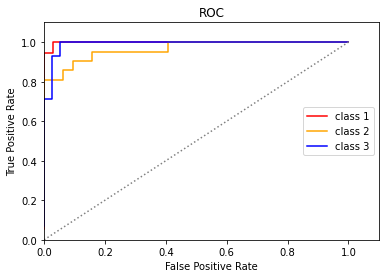

第1类的AUC为：0.998413
第2类的AUC为：0.965774
第3类的AUC为：0.990842


In [15]:
plt.figure()
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.plot(FPR[0], TPR[0], color='red',label="class 1")
plt.plot(FPR[1], TPR[1], color='orange',label="class 2")
plt.plot(FPR[2], TPR[2], color='blue',label="class 3")
plt.plot([0, 1], [0, 1], color='grey', linestyle='dotted')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="right")
plt.show()
for i in range(3):
    print("第{}类的AUC为：{:f}".format(i+1,AUC[i]))